In [ ]:
from pynq import Overlay
from pynq import allocate
import numpy as np
import matplotlib.pyplot as plt
from pynq import MMIO
import time

ol = Overlay("/home/xilinx/jupyter_notebooks/pmod_improv/design_1.bit")

print(ol.ip_dict.keys())   # check that 'axi_dma_0' is listed
dma = ol.axi_dma_0

In [3]:
from pynq import MMIO

# Base address of your AXI GPIO
gpio = MMIO(0x41200000, 0x10000)   # 64KB range is typical

# Write 1024 into the GPIO register
gpio.write(0x0, 4095)

# Optionally, read back to confirm
val = gpio.read(0x0)
print("Frame length register =", val)

Frame length register = 4095


In [44]:
from pynq import Overlay, allocate
import time


# Load bitstream and DMA
#ol = Overlay("your_bitstream.bit")
dma = ol.axi_dma_0

# Your GPIO MMIO setup (from earlier)
from pynq import MMIO
gpio = MMIO(0x40000000, 0x10000)
CH1_DATA = 0x8   # START output
#CH1_TRI  = 0x4
CH2_DATA = 0x0   # DONE input
#CH2_TRI  = 0xC
#gpio.write(CH1_TRI, 0x0)        # channel 1 = output
#gpio.write(CH2_TRI, 0xFFFFFFFF) # channel 2 = input

#def run_transaction():
    # 1. Send start signal
 #   gpio_sig.write(CH1_DATA, 1)
    #print("Start signal sent.")

    # 2. Poll until done signal becomes 1
  #  while True:
   #     done_val = gpio_sig.read(CH2_DATA)
    #    if done_val == 1:
            #print("Done signal detected.")
     #       break
        #gpio_sig.write(GPIO_SIG_CH1, 0)
      #  time.sleep(0.001)
        
    # 4. Clear start signal
    #gpio_sig.write(CH1_DATA, 0)

def acquire_buffer(nwords=1024):
    buffer = allocate(shape=(nwords,), dtype='uint32')

    # Start DMA transfer (DMA is now listening)
    dma.recvchannel.transfer(buffer)

    # Generate samples WHILE DMA is active
   #for _ in range(nwords):
    #    run_transaction()   # each call produces one sample pair

    # Wait for DMA to finish (after TLAST)
    gpio.write(CH1_DATA, 1)
    dma.recvchannel.wait()

    return buffer

# Example: acquire 2 buffers continuously
for i in range(2):
    buf = acquire_buffer(1024)
    voltages_ch1 = [(w & 0x0FFF) * 3.3 / 4095 for w in buf]
    voltages_ch2 = [((w >> 16) & 0x0FFF) * 3.3 / 4095 for w in buf]
    print(f"Buffer {i}: First 5 samples CH1={voltages_ch1[:5]}, CH2={voltages_ch2[:5]}")
gpio.write(CH1_DATA, 0)

Buffer 0: First 5 samples CH1=[0.28849816849816845, 0.28769230769230769, 0.28769230769230769, 0.28769230769230769, 0.28769230769230769], CH2=[0.29010989010989013, 0.29010989010989013, 0.29010989010989013, 0.29010989010989013, 0.29010989010989013]
Buffer 1: First 5 samples CH1=[0.28769230769230769, 0.28849816849816845, 0.28849816849816845, 0.28769230769230769, 0.28769230769230769], CH2=[0.29010989010989013, 0.29010989010989013, 0.29010989010989013, 0.29010989010989013, 0.29010989010989013]


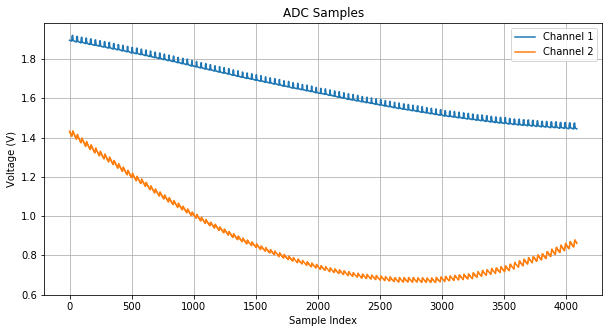

In [96]:
from pynq import Overlay, allocate
import time
import matplotlib.pyplot as plt

# Load bitstream and DMA
# ol = Overlay("your_bitstream.bit")
dma = ol.axi_dma_0

# GPIO MMIO setup
from pynq import MMIO
gpio = MMIO(0x40000000, 0x10000)
CH1_DATA = 0x8   # START output
CH2_DATA = 0x0   # DONE input


def acquire_buffer(nwords=1024):
    buffer = allocate(shape=(nwords,), dtype='uint32')
    dma.recvchannel.transfer(buffer)

    gpio.write(CH1_DATA, 1)
    
    dma.recvchannel.wait()
    
    gpio.write(CH1_DATA, 0)
    

    return buffer

def plot_buffer(buffer):
    
    # Skip the first 7 samples
    buffer = buffer[7:]
    # Convert raw words to voltages
    voltages_ch1 = [(w & 0x0FFF) * 3.3 / 4095 for w in buffer]
    voltages_ch2 = [((w >> 16) & 0x0FFF) * 3.3 / 4095 for w in buffer]
    # Plot both channels
    plt.figure(figsize=(10,5))
    plt.plot(voltages_ch1, label="Channel 1")
    plt.plot(voltages_ch2, label="Channel 2")
    plt.xlabel("Sample Index")
    plt.ylabel("Voltage (V)")
    plt.title("ADC Samples")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
buf = acquire_buffer(4095)
plot_buffer(buf)


<IPython.core.display.Javascript object>


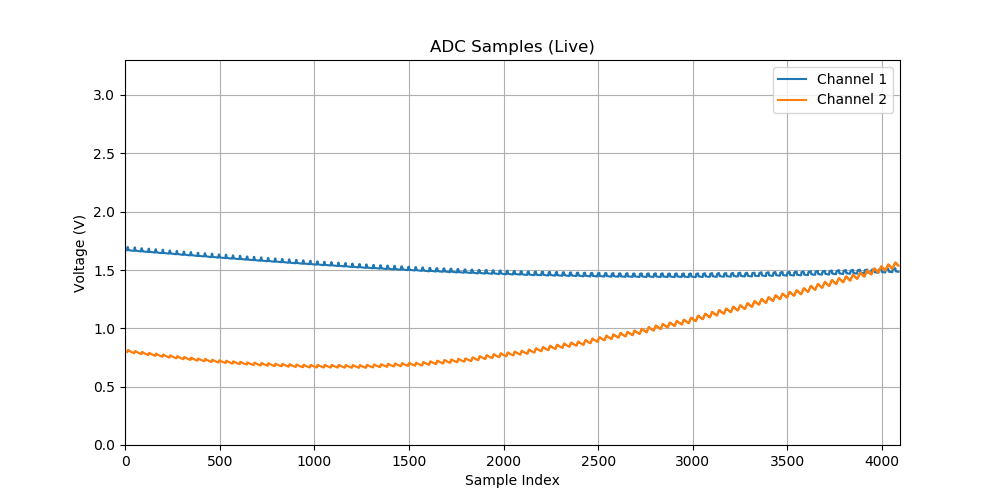

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
from pynq import Overlay, allocate, MMIO

# ol = Overlay("your_bitstream.bit")
dma = ol.axi_dma_0
gpio = MMIO(0x40000000, 0x10000)
CH1_DATA = 0x8
CH2_DATA = 0x0

def acquire_buffer(nwords=1024):
    buffer = allocate(shape=(nwords,), dtype='uint32')
    dma.recvchannel.transfer(buffer)
    gpio.write(CH1_DATA, 1)
    dma.recvchannel.wait()
    gpio.write(CH1_DATA, 0)
    return buffer[7:]  # skip first 7 samples

fig, ax = plt.subplots(figsize=(10,5))
line1, = ax.plot([], [], label="Channel 1")
line2, = ax.plot([], [], label="Channel 2")
ax.set_ylim(0, 3.3)
ax.set_xlim(0, 4095)
ax.set_xlabel("Sample Index")
ax.set_ylabel("Voltage (V)")
ax.set_title("ADC Samples (Live)")
ax.legend()
ax.grid(True)

def update(frame):
    buffer = acquire_buffer(4095)
    voltages_ch1 = [(w & 0x0FFF) * 3.3 / 4095 for w in buffer]
    voltages_ch2 = [((w >> 16) & 0x0FFF) * 3.3 / 4095 for w in buffer]
    line1.set_data(range(len(voltages_ch1)), voltages_ch1)
    line2.set_data(range(len(voltages_ch2)), voltages_ch2)
    return line1, line2

ani = FuncAnimation(fig, update, interval=50, blit=False)